In [2]:
import pandas as pd
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException
import time
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import requests
from bs4 import BeautifulSoup
from PIL import Image
import base64
from PIL import Image
from io import BytesIO
import re
pd.set_option('display.max_rows', None)
def get_stock(S_table):
    '''This function scrapes the data from the Nasdaq website and returns a pandas dataframe with the data.
    Send in the parametars the table you want to scrape. The options are:
    Parameters:
    S_table : str 
        This is the name of the stock table you want to scrape. The options are:
        nextFiscalQ : Next Fiscal Quarter
        nextFiscalY : Next Fiscal Year
        currentQ : Current FiscalQuarter
        currentY : Current Fiscal Year
    
    '''
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--disable-notifications")
    browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    browser.get("https://www.nasdaq.com/market-activity/analyst-forecast-change")

    
    try:
        accept_button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
        accept_button.click()
    except TimeoutException:
        print("Accept button not found or unable to click")
    try:
        WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, f"button.table-tabs__tab[data-value='{S_table}']"))).click()
    except:
        pass
    
    data = []
    last_page_button = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "button.pagination__page:last-child"))
        )
    total_pages = int(last_page_button.get_attribute('data-page'))
    
    for i in range(1, total_pages+1):
        try:
            
            print(f"Processing page {i}")
            
        
            try:
                accept_button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
                accept_button.click()
            except TimeoutException:
                print("Accept button not found or unable to click")

            
            page_number = f".pagination__page[data-page='{i}']"
            element = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, page_number)))
            element.click()
            time.sleep(3)
        except TimeoutException:
            print(f"Timeout while waiting for page {i} to load")
            continue  

        
        
        
        rows = browser.find_elements(By.XPATH, "//table[@class='analyst-forecast-change__table']//tbody//tr")
        if i%3 == 0:
            time.sleep(random.randint(2, 5))
        for row in rows:
            try:
                cells = row.find_elements(By.XPATH, ".//td")
                row_data = [cell.text for cell in cells]
                data.append(row_data)
            except StaleElementReferenceException:
                print("Stale Element Exception occurred while processing row. Trying to re-locate the elements.")
                rows = browser.find_elements(By.XPATH, "//table[@class='analyst-forecast-change__table']//tbody//tr")
                break

    column_names = [
        "Symbol", 
        "Name", 
        "Market", 
        "Current", 
        "1 Week Ago", 
        "% Change", 
        "Total", 
        "Up", 
        "Down"
    ]
    df = pd.DataFrame(data, columns=column_names)




    browser.quit()
    return df

def get_log(company_symbol):
    """
    Retrieves and returns the dividend history as a DataFrame for the specified company symbol from Nasdaq.

    Parameters:
        company_symbol (str): The stock symbol for which to retrieve dividend history.

    Returns:
        pd.DataFrame: A DataFrame containing the dividend history.
    """

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    about_url = f"https://www.nasdaq.com/market-activity/stocks/{company_symbol}/dividend-history"
    driver.get(about_url)
    time.sleep (3)
    try:
        accept_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
        accept_button.click()
    except TimeoutException:
        print("Accept button not found or unable to click")
    time.sleep (3)
    html_content = driver.page_source
    
    soup = BeautifulSoup(html_content, 'html.parser')

    rows = soup.find_all('tr', class_='dividend-history__row--data')

    data = []

    for row in rows:
        cells = row.find_all(['th', 'td'])
        row_data = [cell.get_text(strip=True) for cell in cells]
        data.append(row_data)

    column_names = [
    "Ex/EFF Date", 
    "Type", 
    "Cash Amount", 
    "Declaration Date", 
    "Record Date", 
    "Payment Date"
]

    df_log = pd.DataFrame(data, columns=column_names)
    driver.quit()
    return df_log

def get_recommendation(company_symbol):
    """
    Fetches and returns analyst recommendations for the specified company symbol from Nasdaq.

    Parameters:
        company_symbol (str): The stock symbol for which to retrieve analyst recommendations.

    Returns:
        str: The analyst recommendations text.
    """
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    driver.get(f"https://www.nasdaq.com/market-activity/stocks/{company_symbol}/analyst-research")

    try:
        WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]"))
        ).click()
    except TimeoutException:
        print("No 'I Accept' button found or not clickable.")

    try:
        data_xpath = "/html/body/div[2]/div/main/div[2]/div[4]/div[3]/div/div[1]/div/div[2]/div[2]/div[2]/p"
        
        element_present = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.XPATH, data_xpath))
        )

        driver.execute_script("arguments[0].scrollIntoView(true);", element_present)
        time.sleep(2)  
        data_element = driver.find_element(By.XPATH, data_xpath)

        data_text = data_element.text
        formatted_text = '.\n'.join(data_text.split('. '))

    except TimeoutException:
        print("Timed out waiting for the data to be present.")
        data_text = ""

    driver.quit()

    return formatted_text
def get_graph(company_symbol):
    """
    Generates and displays a graph of analyst target prices for the specified company symbol.

    Parameters:
        company_symbol (str): The stock symbol for which to generate the graph.
    """
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(f"https://www.nasdaq.com/market-activity/stocks/{company_symbol}/analyst-research")
    try:
        WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]"))
        ).click()
    except TimeoutException:
        print("No 'I Accept' button found or not clickable.")

    element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".analyst-target-price__chart-container"))
    )
    driver.execute_script("arguments[0].scrollIntoView();", element)

    time.sleep(2)
    element.screenshot('graph.png')  

    driver.quit()

    image_path = 'graph.png'
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()
def get_photos():
    """
    Downloads and displays the first ten images from the Nasdaq listings events page.
    """
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    about_url = f"https://www.nasdaq.com/solutions/listings/list-your-company"
    driver.get(about_url)
    time.sleep(3)
    try:
        accept_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
        accept_button.click()
    except TimeoutException:
        print("Accept button not found or unable to click")
    time.sleep(3)
    html_content = driver.page_source
    soup = BeautifulSoup(html_content, 'html.parser')

    image_tags = soup.select('.nsdq-l-grid__item img')

    image_tags = image_tags[:10]

    images = []

    if not os.path.exists('Events'):
        os.makedirs('Events')

    for i, img_tag in enumerate(image_tags):
        src = "https://www.nasdaq.com" + img_tag['src']
        if src.startswith('data:image'):
            base64_data = src.split(',')[1]
            img_data = base64.b64decode(base64_data)
            img = Image.open(BytesIO(img_data))
        else:
            driver.get(src)
            img = Image.open(BytesIO(driver.get_screenshot_as_png()))

        images.append(img)
        img_path = f'Events/image_{i}.png'
        img.save(img_path)
        plt.imshow(img)
        plt.show()

    print("Images saved in the 'Events' directory.")
    driver.quit()
def get_news():
    """
    Retrieves and displays the latest news articles from the Nasdaq website.
    and display the companies keywords which is mentioned in the news
    """
    chrome_options = Options()
    chrome_options.add_argument("--disable-notifications")
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--window-size=1920,1080")
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3')
    browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    browser.get("https://www.nasdaq.com/news-and-insights") 
    try:
        WebDriverWait(browser, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "body > div.dialog-off-canvas-main-canvas > div.page.with-jupiter-sticky-nav.with-primary-nav.hide-more-videos.with-sub-nav > main > div.page__content > article > div:nth-child(10) > div.nsdq-l-layout-container--contained.nsdq-l-layout-container.nsdq-u-padding-top-none.nsdq-u-padding-bottom-none > div > div:nth-child(1) > div:nth-child(3) > ul > li"))
        )
    except TimeoutException:
        print("Articles not found on the page.")
    articles_urls=[]
    first_news_item = browser.find_element(By.CSS_SELECTOR, "body > div.dialog-off-canvas-main-canvas > div.page.with-jupiter-sticky-nav.with-primary-nav.hide-more-videos.with-sub-nav > main > div.page__content > article > div:nth-child(10) > div.nsdq-l-layout-container--contained.nsdq-l-layout-container.nsdq-u-padding-top-none.nsdq-u-padding-bottom-none > div > div:nth-child(1) > div:nth-child(3) > ul > li")
    actions = ActionChains(browser)
    actions.move_to_element(first_news_item).perform()
    time.sleep(5)
    article_links = browser.find_elements(By.CSS_SELECTOR, "body > div.dialog-off-canvas-main-canvas > div.page.with-jupiter-sticky-nav.with-primary-nav.hide-more-videos.with-sub-nav > main > div.page__content > article > div:nth-child(10) > div.nsdq-l-layout-container--contained.nsdq-l-layout-container.nsdq-u-padding-top-none.nsdq-u-padding-bottom-none > div > div:nth-child(1) > div:nth-child(3) > ul > li a")
    if article_links:
        print(f"Found {len(article_links)} articles.")
        articles_urls = list(map(lambda link: link.get_attribute("href"), article_links))

    else:
        print("No articles found.")
    articles_content = []
    for link in articles_urls:
        browser.get(link)
        try:
            WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "body > div.dialog-off-canvas-main-canvas > div > main > div.page__content > article > div.nsdq-article-container.nsdq-c-band.nsdq-u-padding-top-none.nsdq-u-padding-bottom-none.nsdq-u-margin-bottom-lg > div.nsdq-l-layout-container--narrow.nsdq-l-layout-container.nsdq-u-padding-top-lg.nsdq-u-padding-bottom-xl > div > div.syndicated-article-main-body.nsdq-l-grid__item > div.syndicated-article-body-wrapper.nsdq-l-grid.nsdq-l-grid--2up-sr-left > div.layout__region.nsdq-l-grid__item.syndicated-article-body > section > div"))
            )
            article_body_element = browser.find_element(By.CSS_SELECTOR, "body > div.dialog-off-canvas-main-canvas > div > main > div.page__content > article > div.nsdq-article-container.nsdq-c-band.nsdq-u-padding-top-none.nsdq-u-padding-bottom-none.nsdq-u-margin-bottom-lg > div.nsdq-l-layout-container--narrow.nsdq-l-layout-container.nsdq-u-padding-top-lg.nsdq-u-padding-bottom-xl > div > div.syndicated-article-main-body.nsdq-l-grid__item > div.syndicated-article-body-wrapper.nsdq-l-grid.nsdq-l-grid--2up-sr-left > div.layout__region.nsdq-l-grid__item.syndicated-article-body > section > div")
            browser.execute_script("arguments[0].scrollIntoView(true);", article_body_element)
            time.sleep(2)
            article_content = browser.find_element(By.CSS_SELECTOR, "body > div.dialog-off-canvas-main-canvas > div > main > div.page__content > article > div.nsdq-article-container.nsdq-c-band.nsdq-u-padding-top-none.nsdq-u-padding-bottom-none.nsdq-u-margin-bottom-lg > div.nsdq-l-layout-container--narrow.nsdq-l-layout-container.nsdq-u-padding-top-lg.nsdq-u-padding-bottom-xl > div > div.syndicated-article-main-body.nsdq-l-grid__item > div.syndicated-article-body-wrapper.nsdq-l-grid.nsdq-l-grid--2up-sr-left > div.layout__region.nsdq-l-grid__item.syndicated-article-body > section > div").text
            articles_content.append(article_content)
        except :
            print("Article content not found.")
            continue
    browser.quit()
    article_symbols = []
    for content, link_element in zip(articles_content, articles_urls):
        found_symbols = set(re.findall(r'\([A-Z]{2,5}\)', content))
        common_words = {'THE', 'AND', 'ARE', 'FOR', 'THIS', 'THAT', 'WITH', 'WILL', 'WHAT', 'WHEN'}
        filtered_symbols = list(filter(lambda symbol: symbol not in common_words, found_symbols))
        article_symbols.append(( link_element, filtered_symbols))
        
    for url, symbols in article_symbols:
        print(f"Article URL: {url}, Symbols: {symbols}")



**Retrieve Data for Next Fiscal Quarter**

This line calls the `get_stock` function with the argument `'nextFiscalQ'` to retrieve stock data for the next fiscal quarter. The data is stored in the variable nextFiscalQ.

In [2]:
nextFiscalQ=get_stock('nextFiscalQ')

Processing page 1
Accept button not found or unable to click
Processing page 2
Accept button not found or unable to click
Processing page 3
Accept button not found or unable to click
Processing page 4
Accept button not found or unable to click
Processing page 5
Accept button not found or unable to click
Processing page 6
Accept button not found or unable to click
Processing page 7
Accept button not found or unable to click
Processing page 8
Accept button not found or unable to click
Processing page 9
Accept button not found or unable to click
Processing page 10
Accept button not found or unable to click
Processing page 11
Accept button not found or unable to click
Processing page 12
Accept button not found or unable to click
Processing page 13
Accept button not found or unable to click
Processing page 14
Accept button not found or unable to click
Processing page 15
Accept button not found or unable to click
Processing page 16
Accept button not found or unable to click


**Documentation for `get_stock` Function**

And it has been written in all functions in the project.

In [2]:
help(get_stock)

Help on function get_stock in module __main__:

get_stock(S_table)
    This function scrapes the data from the Nasdaq website and returns a pandas dataframe with the data.
    Send in the parametars the table you want to scrape. The options are:
    Parameters:
    S_table : str 
        This is the name of the stock table you want to scrape. The options are:
        nextFiscalQ : Next Fiscal Quarter
        nextFiscalY : Next Fiscal Year
        currentQ : Current FiscalQuarter
        currentY : Current Fiscal Year



**Display Data for Next Fiscal Quarter**

This line outputs the content of the `nextFiscal` variable, typically a pandas DataFrame containing the scraped data for the next fiscal quarter.

In [3]:
nextFiscalQ

,Symbol,Name,Market,Current,1 Week Ago,% Change,Total,Up,Down
0,AIG,"American International Group, Inc.",NYSE,1.79,1.78,1%,6,1,0
1,ALK,"Alaska Air Group, Inc.",NYSE,2.17,2.15,1%,6,1,1
2,ALL,Allstate Corporation (The),NYSE,1.66,1.65,1%,8,1,1
3,ALNY,"Alnylam Pharmaceuticals, Inc.",NASDAQ -GS,-1.17,-1.18,1%,10,1,0
4,ARI,Apollo Commercial Real Estate Finance,NYSE,0.35,0.34,1%,2,1,0
5,ASB,Associated Banc-Corp,NYSE,0.53,0.52,1%,4,1,0
6,BEN,"Franklin Resources, Inc.",NYSE,0.62,0.61,1%,5,2,0
7,BMY,Bristol-Myers Squibb Company,NYSE,1.78,1.75,1%,9,1,2
8,BXMT,"Capital Trust, Inc.",NYSE,0.52,0.51,1%,2,1,0
9,C,Citigroup Inc.,NYSE,1.58,1.57,1%,11,1,1


**Retrieve Dividend History for AGNC**

This line executes the `get_log` function with the argument `AGNC` to fetch the dividend history of the AGNC stock, returning the data as a DataFrame.

In [5]:
get_log('AGNC')

,Ex/EFF Date,Type,Cash Amount,Declaration Date,Record Date,Payment Date
0,04/29/2024,Cash,$0.12,04/10/2024,04/30/2024,05/09/2024
1,03/27/2024,Cash,$0.12,03/13/2024,03/29/2024,04/09/2024
2,02/28/2024,Cash,$0.12,02/08/2024,02/29/2024,03/11/2024
3,01/30/2024,Cash,$0.12,01/10/2024,01/31/2024,02/09/2024
4,12/28/2023,Cash,$0.12,12/13/2023,12/29/2023,01/10/2024
5,11/29/2023,Cash,$0.12,11/08/2023,11/30/2023,12/11/2023
6,10/30/2023,Cash,$0.12,10/11/2023,10/31/2023,11/09/2023
7,09/28/2023,Cash,$0.12,09/13/2023,09/29/2023,10/11/2023
8,08/30/2023,Cash,$0.12,08/09/2023,08/31/2023,09/12/2023
9,07/28/2023,Cash,$0.12,07/12/2023,07/31/2023,08/09/2023


**Generate and Display Graph for AGNC**

This command calls the `get_graph` function with `AGNC` as the argument to generate and display a graph of analyst target prices for the AGNC stock.

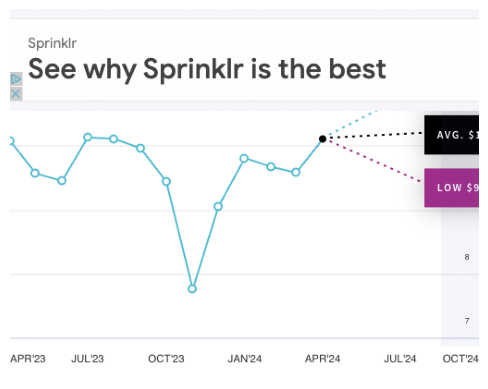

In [6]:
get_graph('AGNC')

**Retrieve Analyst Recommendation for AGNC**

This line uses the `get_recommendation` function with `AGNC` as the argument to fetch and return the latest analyst recommendations for the AGNC stock.

In [6]:
get_recommendation('AGNC')

'Based on analysts offering 12 month price targets for AGNC in the last 3 months.\nThe average price target is $10.1 with a high estimate of $10.75 and a low estimate of $9.\nSign in to your SmartPortfolio to see more analyst recommendations.'

The `get_news` function automates the process of retrieving the latest news articles from the Nasdaq website using Selenium WebDriver. It collects and displays URLs for each article and extracts mentioned company symbols from the content, excluding common words that could be mistakenly captured as symbols.
Used `re` (Regular expressions) and `lambda`


In [3]:
get_news()

Found 10 articles.
Article URL: https://www.nasdaq.com/articles/advisors-need-to-know-where-alternatives-fit, Symbols: []
Article URL: https://www.nasdaq.com/articles/increase-flexibility-by-outsourcing-portfolio-construction, Symbols: []
Article URL: https://www.nasdaq.com/articles/vsec-about-to-put-more-money-in-your-pocket, Symbols: []
Article URL: https://www.nasdaq.com/articles/you-wont-believe-what-elon-musk-just-said, Symbols: []
Article URL: https://www.nasdaq.com/articles/franklin-resources-q2-24-earnings-conference-call-at-11%3A00-am-et, Symbols: ['(BEN)', '(US)']
Article URL: https://www.nasdaq.com/articles/mysterious-2010-bitcoin-whale-launches-bitcoin-only-market-making-certificate, Symbols: ['(BTCY)', '(BITO)']
Article URL: https://www.nasdaq.com/articles/cathie-wood-goes-bargain-hunting%3A-3-stocks-she-just-bought-101, Symbols: []
Article URL: https://www.nasdaq.com/articles/is-amgen-stock-a-buy-for-its-3-yield, Symbols: ['(GS)', '(AMGN)']
Article URL: https://www.nasdaq

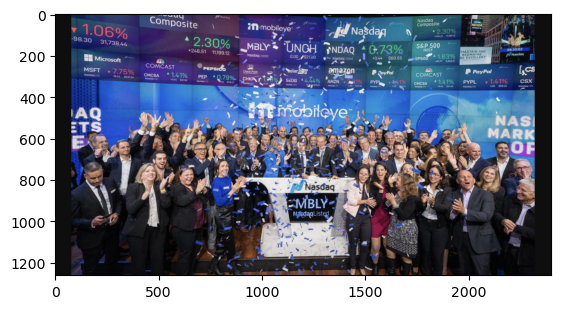

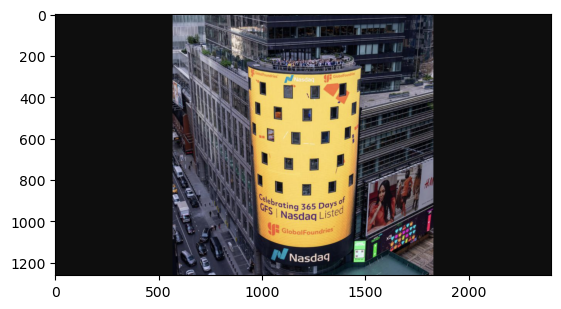

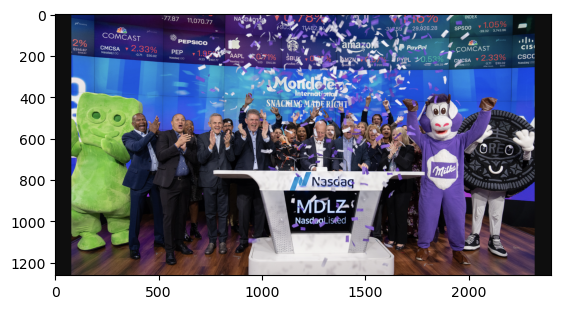

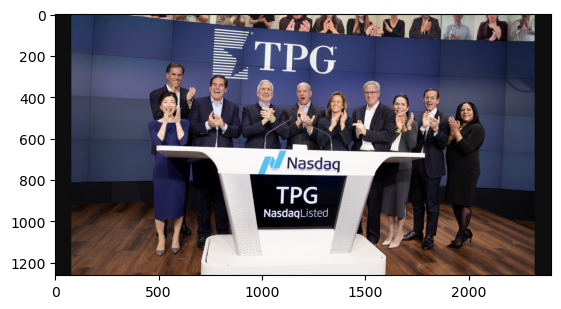

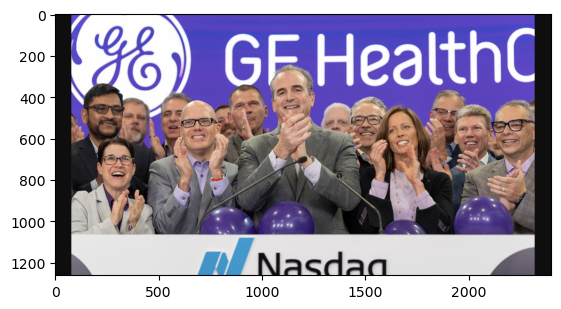

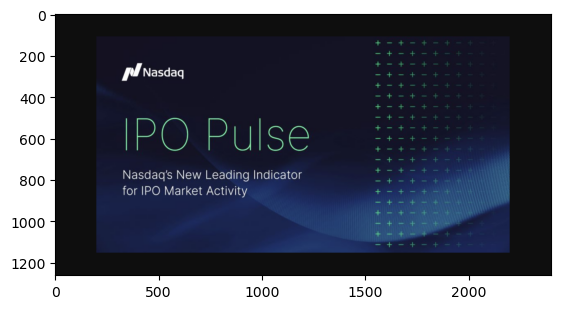

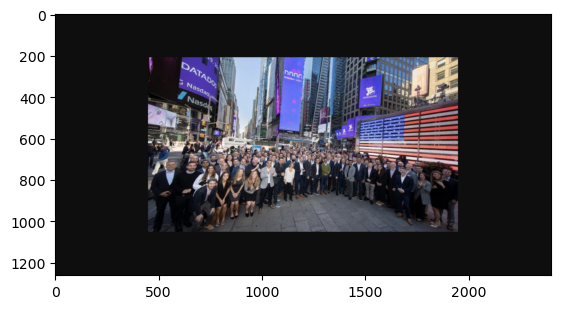

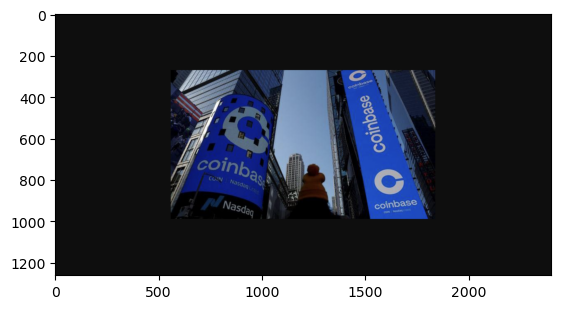

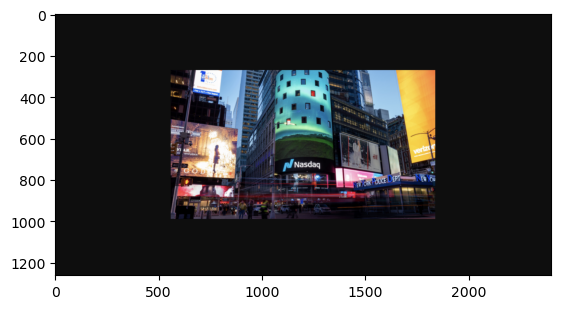

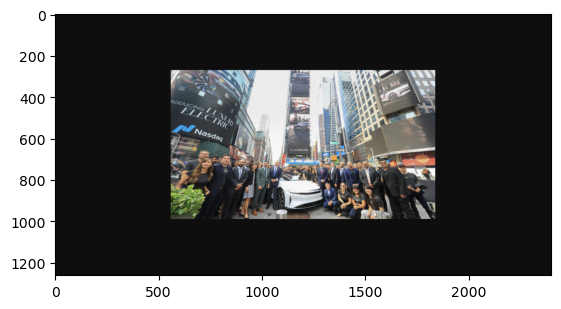

Images saved in the 'Events' directory.


In [8]:
get_photos()